In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import rasterio
from rasterio.plot import show
import xarray as xr
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [2]:
roads = gpd.read_file('../road_transport_interurban_CAT.geojson')

KeyboardInterrupt: 

In [3]:
roads = roads.to_crs(epsg=25831)


In [4]:
if not roads.geometry.all().is_valid:
    print("Warning: Invalid geometries found. Applying buffer(0) to fix.")
    roads.geometry = roads.geometry.buffer(0)

# Extract relevant columns if needed (assuming 'imd_tot' is the traffic info)
roads = roads[['imd_tot', 'geometry']]

In [5]:
# Get the bounding box of all roads to define the extent of Catalonia  
minx, miny, maxx, maxy = (423154.12, 4573055.718720723, 435554.1200378428, 4590555.718720723  )

In [6]:
maxy

4590555.718720723

In [7]:
from shapely.geometry import Polygon
import numpy as np

# Define the cell size
cell_size = 25

# Generate grid cells
grid_cells = []
for x in np.arange(minx, maxx, cell_size):
    for y in np.arange(miny, maxy, cell_size):
        # Create a polygon for each cell
        grid_cells.append(Polygon([(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)]))

# Create a GeoDataFrame from the grid cells
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=roads.crs)

KeyboardInterrupt: 

In [26]:
# Perform a spatial join to find which grid cells intersect with roads
joined = gpd.sjoin(grid, roads, how='left', predicate='intersects')

In [27]:
# Group by grid cell index and calculate the desired statistic (e.g., mean, sum)
# We will use mean in this example, but you can change it to sum or another function
aggregated_grid = joined.groupby(joined.index)['imd_tot'].mean().reset_index()
aggregated_grid.rename(columns={'imd_tot': 'mean_imd_tot'}, inplace=True)

# Merge the aggregated values back to the original grid
grid = grid.merge(aggregated_grid, left_index=True, right_index=True, how='left')

# Fill NaN values with 0 (or another appropriate value)
grid['mean_imd_tot'] = grid['mean_imd_tot'].fillna(0)

In [28]:
# Save the grid with aggregated traffic information to a new GeoJSON file
grid.to_file('catalonia_traffic_grid_25m.geojson', driver='GeoJSON')

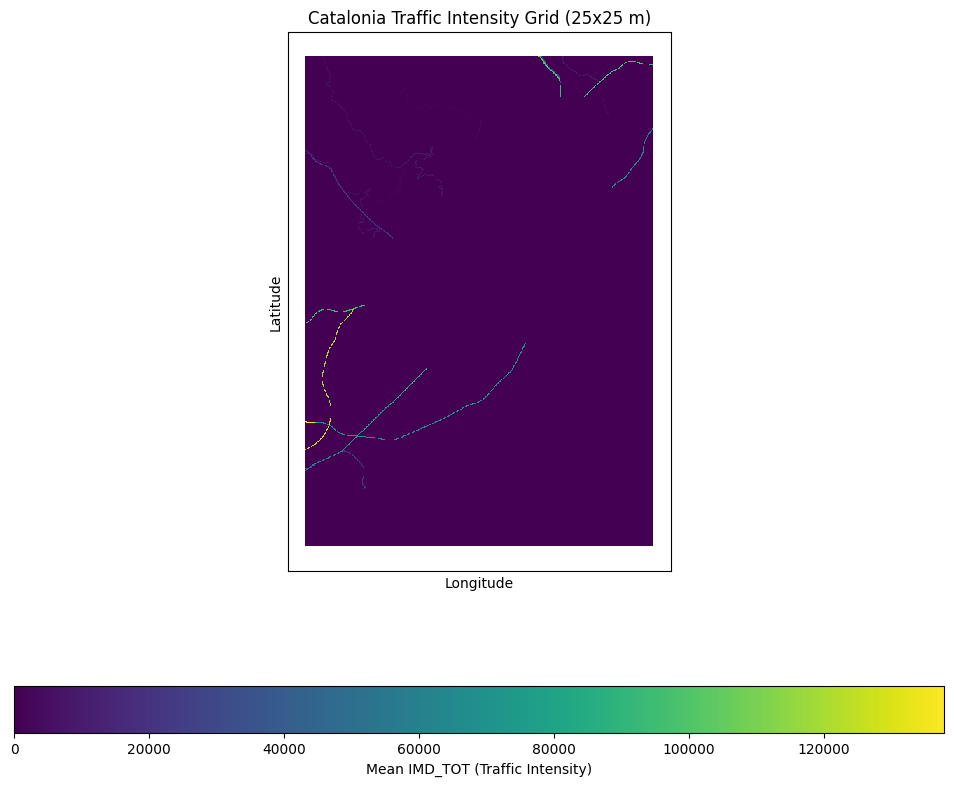

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the grid data (if you haven't already)
grid = gpd.read_file('catalonia_traffic_grid_25m.geojson')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the grid with 'mean_imd_tot' values
grid.plot(column='mean_imd_tot', ax=ax, legend=True,
          legend_kwds={'label': "Mean IMD_TOT (Traffic Intensity)", 'orientation': "horizontal"},
          cmap='viridis')  # You can choose a different colormap

# Customize the plot
ax.set_title('Catalonia Traffic Intensity Grid (25x25 m)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove axis ticks if desired
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

In [4]:
import geopandas as gpd
import glob

# Path to the directory containing the shapefiles for each province
road_links_dir = '../OpenTransportMap/'

# Use glob to find all .shp files within the directory and subdirectories
shapefiles = glob.glob(road_links_dir + '/**/roadlinks_*.shp', recursive=True)

# Create an empty list to store GeoDataFrames
gdfs = []

# Load each shapefile and append to the list
for shp in shapefiles:
    try:
        gdf = gpd.read_file(shp)
        gdfs.append(gdf)
    except Exception as e:
        print(f"Error reading {shp}: {e}")

# Check if any GeoDataFrames were loaded
if not gdfs:
    raise FileNotFoundError("No valid shapefiles found.")

# Concatenate all GeoDataFrames in the list
road_links = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

# Reproject to the same CRS as the grid (if necessary)
road_links = road_links.to_crs(epsg=25831) # Assuming the grid is still in EPSG:25831

# Optional: Keep only necessary columns if the shapefiles have many attributes
# road_links = road_links[['geometry', 'id']]  # Example: Keep only geometry and id

In [5]:
# Load the grid data (if you haven't already)
grid = gpd.read_file('catalonia_traffic_grid_25m.geojson')
grid = grid.to_crs(epsg=25831)
# Calculate the centroid of each grid cell
grid['centroid'] = grid.centroid

In [11]:
road_links = road_links.to_crs(epsg=25831) 

In [12]:
grid = gpd.read_file('catalonia_traffic_grid_25m.geojson')


In [23]:
grid = grid.to_crs(epsg=25831)

In [25]:
road_links.columns

Index(['inspireid', 'sourceid', 'beginlifes', 'endlifespa', 'validfrom',
       'validto', 'fictitious', 'direction', 'fromroadno', 'toroadnode',
       'roadname', 'nationalro', 'functional', 'formofway', 'roadsurfac',
       'speedlimit', 'capacity', 'maximuheig', 'maximumtot', 'maximumwid',
       'vehicletyp', 'z_order', 'length_m', 'trafficvol', 'geometry'],
      dtype='object')

In [26]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx  # Optional for basemap
import glob

# Perform spatial join to identify grid cells intersecting with road links
joined_roads = gpd.sjoin(grid, road_links, how='left', predicate='intersects')

# Determine if a cell has any road intersection (True/False)
grid['has_road'] = joined_roads.groupby(road_links.index)['index_right'].any()
grid['has_road'] = grid['has_road'].fillna(False)  # Fill NaN with False (no intersection)

# --- 4. Plotting (with or without basemap) ---

# Reproject to Web Mercator if using contextily
grid = grid.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the grid, coloring by 'has_road'
grid.plot(column='has_road', ax=ax, legend=True, cmap='Set2')

# Add basemap (optional)
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title('Catalonia Grid (25x25 m) with Road Intersection Indicator')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19884\1795403531.py:9: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3857
Right CRS: EPSG:25831

  joined_roads = gpd.sjoin(grid, road_links, how='left', predicate='intersects')


KeyboardInterrupt: 

In [9]:
# Save the grid to a GeoJSON file
output_file = "catalonia_grid_with_roads.geojson"
grid.to_file(output_file, driver="GeoJSON")

print(f"Grid saved to {output_file}")


Grid saved to catalonia_grid_with_roads.geojson


In [27]:
grid = gpd.read_file("catalonia_grid_with_roads.geojson")

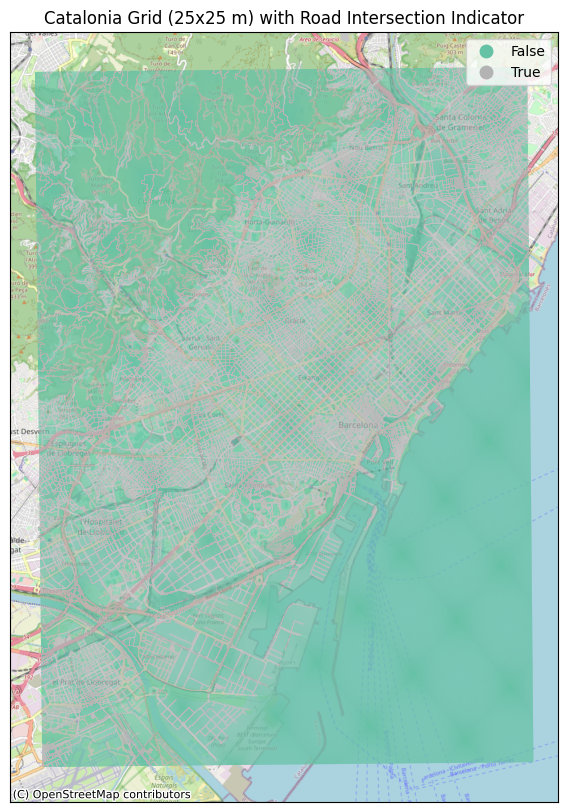

In [28]:
grid = grid.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the grid, coloring by 'has_road'
grid.plot(column='has_road', ax=ax, legend=True, cmap='Set2')

# Add basemap (optional)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title('Catalonia Grid (25x25 m) with Road Intersection Indicator')
ax.set_xticks([])
ax.set_yticks([])
plt.show()